In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy as sp

In [72]:
d = np.load('data1.npz')
lat = d['lat'];lon = d['lon'];u=d['u']

In [94]:
def plot_field(lat,lon,u,time,levels=20):
    """
    Generate contour plot of u at particular time
    Use if/as needed
    Input:
    lat,lon: latitude and longitude arrays
    u: full array of wind speed data
    time: time at which wind speed will be plotted (index between 0 and 364)
    levels: number of contour levels in plot
    """
    


    plt.figure()
    plt.contourf(lon,lat,u[time,:,:],levels)
    plt.axis('equal')
    plt.grid()
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    return None

In [200]:
n = len(lon)
m = len(lat)
X = u.reshape(365, -1)
np.shape(X)

(365, 2304)

In [239]:
A = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)
U, S, WT = np.linalg.svd(A)
T = U.T
Anew = np.matmul(T, A)
explained_variance = S**2 / np.sum(S**2)
n = 1
#n = np.argmax(np.cumsum(explained_variance) > 0.9)
Areduced = np.matmul(U[:, :n], Anew[:n, :])
u_reduced = (Areduced * np.std(X, axis = 0) + np.mean(X, axis = 0)).reshape(np.shape(u))


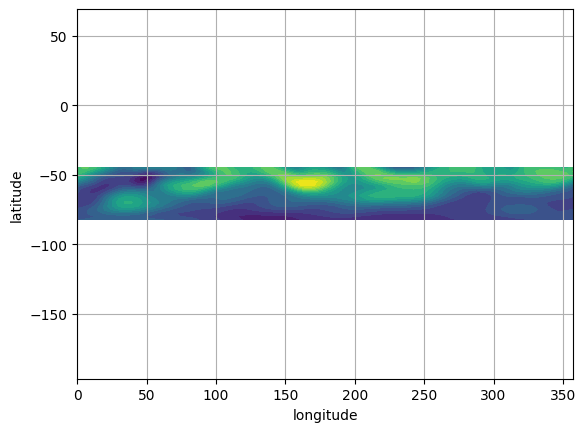

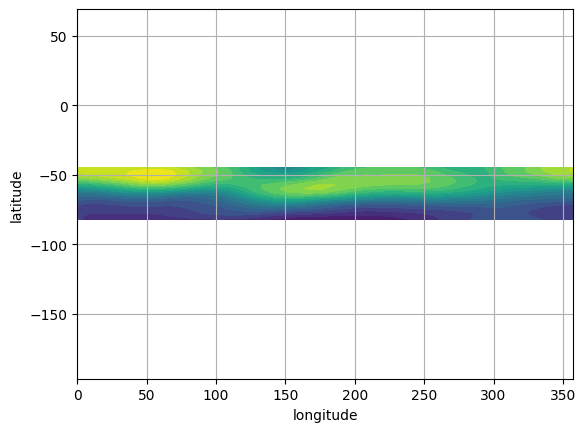

In [240]:
plot_field(lat, lon, u, 0)
plot_field(lat, lon, u_reduced, 0)

In [241]:
F = u.reshape(365, -1)
F_hat = np.fft.fft2(F)
F_hat_reshaped = F_hat.reshape(np.shape(u))

/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/matplotlib/contour.py:1565: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/matplotlib/contour.py:1566: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


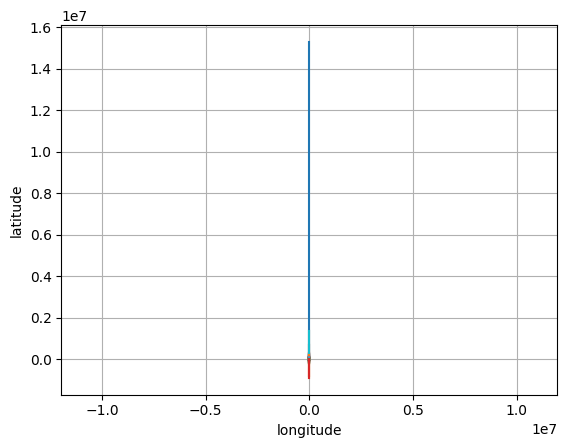

In [245]:
plot_field(lat, lon, F_hat_reshaped, 150)
plt.plot(F_hat_reshaped[0])

In [220]:
def part2(f,method=2):
    """
    Question 2.1 i)
    Input:
        f: m x n array
        method: 1 or 2, interpolation method to use
    Output:
        fI: interpolated data (using method)
    """

    m,n = f.shape
    fI = np.zeros((m-1,n)) #use/modify as needed

    if method==1:
        fI = 0.5*(f[:-1,:]+f[1:,:])
    else:
        #Coefficients for method 2
        alpha = 0.3
        a = 1.5
        b = 0.1
        
        #coefficients for near-boundary points
        a_bc,b_bc,c_bc,d_bc = (5/16,15/16,-5/16,1/16)

        #add code here
        #using linear system representation of interpolation, form LHS and RHS coefficient matrices
        #first make LHS coefficients including adjustments for i = 1/2 and i = m - 3/2
        alphas_upper = alpha * np.ones(m-2)
        alphas_upper[0] = 0
        alphas_lower = alphas_upper[::-1]

        #formulate these into sparse matrix
        LHS_coefs = sp.sparse.diags([alphas_lower, np.ones(m-1), alphas_upper], [-1, 0, 1], (m-1, m-1))

        #now make RHS coefficients, again taking care of i = 1/2 and i = m - 3/2 cases
        a_halves_lower = a * np.ones(m-1) / 2
        a_halves_lower[0] = a_bc
        a_halves_lower[-1] = b_bc
        a_halves_upper = a_halves_lower[::-1]

        b_halves_lower = b * np.ones(m-2) / 2
        b_halves_lower[-1] = c_bc
        b_halves_upper = b_halves_lower[::-1]

        d_lower = np.zeros(m-3)
        d_lower[-1] = d_bc
        d_upper = d_lower[::-1]

        #formulate matrix
        RHS_coefs = sp.sparse.diags([d_lower, b_halves_lower, a_halves_lower, a_halves_upper, b_halves_upper, d_upper], [-2, -1, 0, 1, 2, 3], (m-1, m))

        #make f sparse for quicker computations
        sparse_f = sp.sparse.csr_matrix(f)

        #evaluate the RHS
        RHS = RHS_coefs @ sparse_f

        #use spsolve to solve system of form AX = B where A, B, X all matrices
        fI = sp.sparse.linalg.spsolve(LHS_coefs, RHS).toarray()

    return fI #modify as needed

In [68]:
f = np.random.random((10, 10))
part2(f, method = 1)

array([[0.69887285, 0.50789226, 0.16516398, 0.27471043, 0.11288529,
        0.17886613, 0.19653168, 0.71190456, 0.50189753, 0.40705382],
       [0.6851409 , 0.75615837, 0.18157045, 0.65039936, 0.16004078,
        0.17970094, 0.32433604, 0.39753103, 0.79613428, 0.19591187],
       [0.81771036, 0.57797255, 0.60253174, 0.5057872 , 0.20904168,
        0.28869733, 0.48643231, 0.37889644, 0.45770388, 0.35995296],
       [0.77301923, 0.31335864, 0.48461429, 0.3993067 , 0.55518729,
        0.4563068 , 0.19431694, 0.4699565 , 0.3654132 , 0.62328083],
       [0.59191201, 0.36123458, 0.28149078, 0.79254251, 0.88631639,
        0.76601912, 0.4835455 , 0.6708747 , 0.3501742 , 0.6091111 ],
       [0.34805806, 0.41061649, 0.48692391, 0.78189426, 0.56032577,
        0.4928923 , 0.87255329, 0.96408094, 0.14312268, 0.54888513],
       [0.1850201 , 0.66840073, 0.73065539, 0.78897575, 0.4996182 ,
        0.48158294, 0.69268997, 0.54671313, 0.18678933, 0.39986973],
       [0.09163372, 0.54583585, 0.7059800

In [74]:
part2(u[0])

/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


array([[39.8974335 , 40.04342189, 39.47727092, ..., 37.98316974,
        38.47453343, 39.25110668],
       [38.359542  , 36.44287705, 33.90790814, ..., 40.61607022,
        40.31580081, 39.63181381],
       [32.8866881 , 29.68049805, 26.28337342, ..., 39.81096339,
        38.12163465, 35.76556293],
       ...,
       [ 5.78376612,  6.50053971,  7.33563449, ...,  4.33080316,
         4.69938585,  5.18369652],
       [ 6.08834194,  6.55418117,  7.06100702, ...,  4.97387714,
         5.28584562,  5.6618189 ],
       [ 6.56917507,  6.82462097,  7.09448837, ...,  5.8148701 ,
         6.05823475,  6.315538  ]])

In [77]:
part2(u[0], method = 1)

AttributeError: 'list' object has no attribute 'shape'

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 640x480 with 0 Axes>

In [86]:
np.shape(part2(u[0]))

/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/calam/Year 3/pers_venv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


(15, 144)

In [98]:
def part3q1(y0,alpha,beta,b,c,tf=200,Nt=800,err=1e-6,method="RK45"):
    """
    Part 3 question 1
    Simulate system of 2n nonlinear ODEs

    Input:
    y0: Initial condition, size 2*n array
    alpha,beta,b,c: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    yarray: Nt+1 x 2*n array containing y at
            each time step including the initial condition.
    """
    
    #Set up parameters, arrays

    n = y0.size//2
    tarray = np.linspace(0,tf,Nt+1)
    yarray = np.zeros((Nt+1,2*n))
    yarray[0,:] = y0


    def RHS(t,y):
        """
        Compute RHS of model
        """
        #add code here
        u = y[:n];v=y[n:]
        r2 = u**2+v**2
        nu = r2*u
        nv = r2*v
        cu = np.roll(u,1)+np.roll(u,-1)
        cv = np.roll(v,1)+np.roll(v,-1)

        dydt = alpha*y
        dydt[:n] += beta*(cu-b*cv)-nu+c*nv+b*(1-alpha)*v
        dydt[n:] += beta*(cv+b*cu)-nv-c*nu-b*(1-alpha)*u

        return dydt


    sol = solve_ivp(RHS, (tarray[0],tarray[-1]), y0, t_eval=tarray, method=method,atol=err,rtol=err)
    yarray = sol.y.T 
    return tarray,yarray

In [121]:
def part3q2(x,c=1.0):
    """
    Code for part 3, question 2
    """
    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000

    #Set initial conidition
    y0 = np.zeros(2*n) #I EDITTED THIS CHECK IT MATE
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

    #Compute solution
    t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
    y0 = y[-1,:]
    t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
    A = y[:,:n]

    #Analyze code here
    l1,v1 = np.linalg.eigh(A.T.dot(A))
    v2 = A.dot(v1)
    A2 = (v2[:,:x]).dot((v1[:,:x]).T)
    e = np.sum((A2.real-A)**2)

    return A2,e,A

In [141]:
A2, errors, A = part3q2(99)

In [123]:
U, S, WT = np.linalg.svd(A)
S

array([1.26027598e+03, 8.29483962e+01, 3.44244737e+01, 6.53116420e+00,
       2.98764275e+00, 2.17442674e+00, 1.16027249e+00, 5.57881164e-01,
       3.90430644e-01, 2.26482098e-01, 1.28466161e-01, 8.99559640e-02,
       6.10214030e-02, 4.68976247e-02, 3.37833620e-02, 1.74289631e-02,
       1.07786472e-02, 7.81768368e-03, 4.64867925e-03, 2.05113316e-03,
       1.31059701e-03, 1.28562047e-03, 8.83261653e-04, 6.86465097e-04,
       3.91574226e-04, 3.58651041e-04, 2.89262002e-04, 1.87616927e-04,
       1.56515227e-04, 1.36099711e-04, 9.70859414e-05, 9.03244999e-05,
       6.55396029e-05, 5.56213819e-05, 4.90190730e-05, 3.75704299e-05,
       3.02226177e-05, 1.81241897e-05, 1.76652857e-05, 1.45310523e-05,
       1.21305084e-05, 9.77077111e-06, 7.80058097e-06, 4.80323552e-06,
       4.50694165e-06, 3.40032128e-06, 3.15796306e-06, 2.33628441e-06,
       1.96412203e-06, 1.72089021e-06, 1.51538027e-06, 1.28585736e-06,
       1.03815298e-06, 9.28481178e-07, 8.02592115e-07, 5.49985677e-07,
      

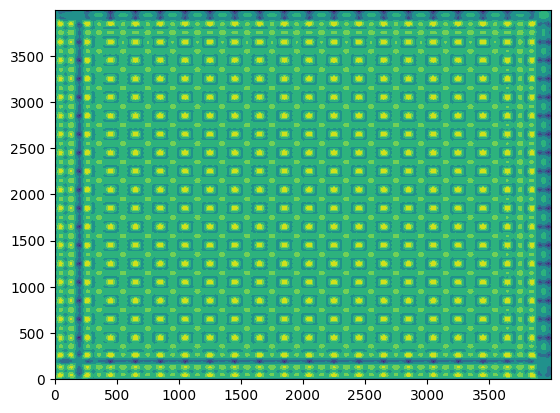

In [142]:
plt.contourf(A.T.dot(A))

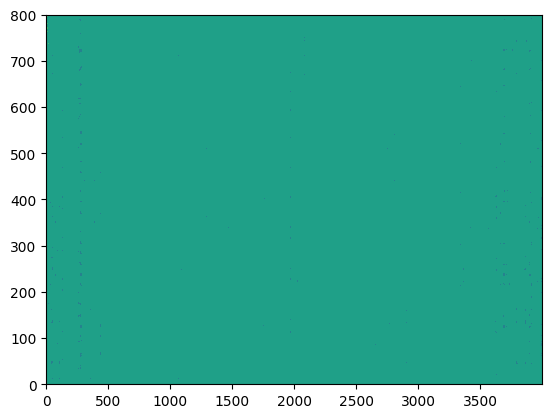

In [145]:
plt.contourf(A2)

In [115]:
np.linalg.matrix_rank(A)

99

In [116]:
np.linalg.matrix_rank(A2)

10

In [128]:
np.max(A2)

2.1271243191129745e-06

In [146]:
A.T.dot(A)

array([[394.70170268, 394.76583736, 394.82850711, ..., 394.50763356,
        394.57208576, 394.63708442],
       [394.76583736, 394.83823756, 394.9093979 , ..., 394.54842367,
        394.62040698, 394.69319023],
       [394.82850711, 394.9093979 , 394.98929104, ..., 394.58717584,
        394.66686429, 394.74762308],
       ...,
       [394.50763356, 394.54842367, 394.58717584, ..., 394.37985862,
        394.42286147, 394.46575294],
       [394.57208576, 394.62040698, 394.66686429, ..., 394.42286147,
        394.47281495, 394.52285922],
       [394.63708442, 394.69319023, 394.74762308, ..., 394.46575294,
        394.52285922, 394.58027564]])